In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib.offsetbox import AnchoredText

import xarray as xr 

import metpy
from metpy.units import units
import metpy.calc as mpcalc

### read in data

#### this file was created using /Users/rschumac/weather/21dec22_coldfront/akron_fluxtower_diagnostics.ipynb

#### it already includes the wind direction correction and calculation of air temp from sonic

In [2]:
usda = pd.read_csv("usda_akron_21dec2022.csv",
                  parse_dates=['TIMESTAMP'])

usda['TIMESTAMP'] = pd.to_datetime(usda['TIMESTAMP'], format='mixed')
#.dt.tz_localize("UTC")

usda.set_index("TIMESTAMP", inplace=True)

usda

,Date_Time,DATAH,Seconds,Nanoseconds,Sequence Number,Diagnostic Value,Diagnostic Value 2,DS Diagnostic Value,CO2 Absorptance,H2O Absorptance,...,CH4 Diagnostic Value,CH4 Drop Rate (%),CHK,pressure,wspd,wdir_corr,uuu_corr,vvv_corr,spfh,Ta_sonic
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2022-12-21 19:00:00+00:00,12/21/22 12:00:00:000,DATA,1671649200,0,52972950,253,1,0,0.119107,0.024383,...,16463,0,52,853.645,5.558703,256.153062,5.397159,1.330359,0.002492,6.035320
2022-12-21 19:00:00.100000+00:00,12/21/22 12:00:00:100,DATA,1671649200,100000000,52972980,253,1,0,0.119138,0.024395,...,16991,0,102,853.636,5.950902,250.939333,5.624633,1.943381,0.002497,5.854724
2022-12-21 19:00:00.200000+00:00,12/21/22 12:00:00:200,DATA,1671649200,200000000,52973010,253,1,0,0.119125,0.024465,...,16991,0,177,853.622,5.102559,252.035694,4.853804,1.573754,0.002498,5.829215
2022-12-21 19:00:00.300000+00:00,12/21/22 12:00:00:300,DATA,1671649200,300000000,52973040,253,1,0,0.119107,0.024466,...,16991,0,241,853.614,5.243644,252.133566,4.990766,1.608745,0.002487,5.959371
2022-12-21 19:00:00.400000+00:00,12/21/22 12:00:00:400,DATA,1671649200,400000000,52973070,253,1,0,0.119132,0.024389,...,16991,0,123,853.659,5.903413,259.929744,5.812466,1.032245,0.002505,5.797074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-21 21:59:59.500000+00:00,12/21/22 14:59:59:500,DATA,1671659999,500000000,56212800,253,1,0,0.127938,0.010043,...,16463,0,42,857.297,10.103359,14.250986,-2.487144,-9.792445,0.000878,-13.178901
2022-12-21 21:59:59.600000+00:00,12/21/22 14:59:59:600,DATA,1671659999,600000000,56212830,253,1,0,0.127873,0.010337,...,16463,0,220,857.283,9.923523,20.035891,-3.399885,-9.322934,0.000871,-13.147756
2022-12-21 21:59:59.700000+00:00,12/21/22 14:59:59:700,DATA,1671659999,700000000,56212860,253,1,0,0.128031,0.010290,...,16463,0,9,857.253,10.827170,13.557146,-2.538052,-10.525489,0.000877,-13.145224


### 2-panel plot

#### bring in ASOS first for comparison

In [3]:
asos = pd.read_csv("KAKO_1min_asos_dec2022.csv",
                  parse_dates=['valid(UTC)'])
    
asos['datetime'] = asos['valid(UTC)'].dt.tz_localize("UTC")
asos.set_index("datetime", inplace=True)

### F to C
#asos['tmpc'] = (asos['tmpf']-32.)/1.8
asos['tmpc'] = (pd.to_numeric(asos['tmpf'], errors='coerce')-32.)/1.8

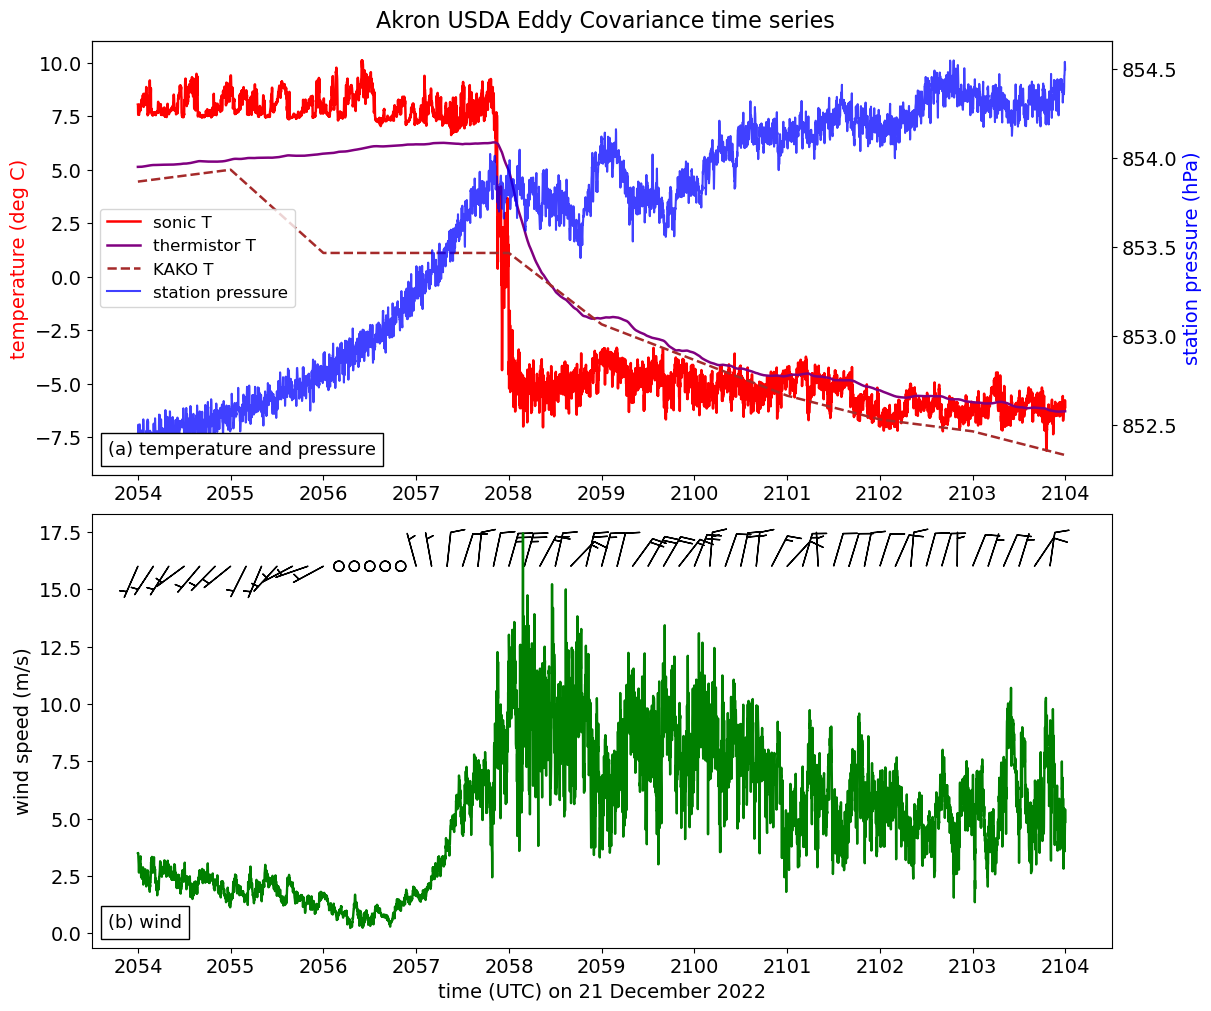

In [4]:
data_sub = usda['2022-12-21 20:54':'2022-12-21 21:03']
asos_sub = asos['2022-12-21 20:54':'2022-12-21 21:04']

# Plot the raw time series
fig, axs = plt.subplot_mosaic([
    ['t and p'],
    ['wind'],
], layout='constrained', figsize=(12,10))

axs['t and p'].plot(data_sub.index,data_sub['Ta_sonic'], label='sonic T', color='red', lw=1.8, zorder=12)
axs['t and p'].plot(data_sub.index,data_sub['Temperature (C)'], label='thermistor T', color='purple', lw=1.8, zorder=12)
axs['t and p'].plot(asos_sub.index,asos_sub['tmpc'], label='KAKO T', color='brown', 
                    linestyle='dashed', lw=1.8, zorder=12)

axs['t and p'].set_ylabel("temperature (deg C)", fontsize=14, color='red')
axs['t and p'].tick_params(axis='both', labelsize=14)

ax2 = axs['t and p'].twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(data_sub.index,data_sub['pressure'],label='station pressure', color='blue', lw=1.5, zorder=10, alpha=0.75)

ax2.set_ylabel("station pressure (hPa)", fontsize=14, color='blue')
ax2.tick_params(axis='both', labelsize=14)

# Define the date format
date_form = DateFormatter("%H%M")
ax2.xaxis.set_major_formatter(date_form)
# Ensure ticks fall once every other minute (interval=2) 
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))

### panel label
text = AnchoredText("(a) temperature and pressure",
                loc='lower left', prop={'size': 13}, frameon=True, zorder=20)
ax2.add_artist(text)

# ask matplotlib for the plotted objects and their labels
lines, labels = axs['t and p'].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, fontsize=12, loc='center left')


### now do wind
axs['wind'].plot(data_sub.index,data_sub['wspd'], label='wind speed', color='green', lw=1.7, zorder=6)
## add barbs
thin_by = 100  ## plot a barb every nth time
axs['wind'].barbs(data_sub.index[::thin_by],16.,data_sub['uuu_corr'][::thin_by]*1.943844,data_sub['vvv_corr'][::thin_by]*1.943844)

axs['wind'].set_ylabel("wind speed (m/s)", fontsize=14)
axs['wind'].tick_params(axis='both', labelsize=14)
axs['wind'].set_xlabel("time (UTC) on 21 December 2022", fontsize=14)

### date format again
axs['wind'].xaxis.set_major_formatter(date_form)
axs['wind'].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))

#axs['wind'].legend(fontsize=14)
### panel label
text = AnchoredText("(b) wind",
                loc='lower left', prop={'size': 13}, frameon=True, zorder=20)
axs['wind'].add_artist(text)

plt.suptitle("Akron USDA Eddy Covariance time series", fontsize=16)

plt.savefig("akron_ec_2panel_tser.pdf", dpi=275, 
            bbox_inches='tight', transparent=False, facecolor='white')

plt.show()



In [5]:
data_sub['Ta_sonic']['2022-12-21 20:57:55':]

TIMESTAMP
2022-12-21 20:57:55+00:00           0.684095
2022-12-21 20:57:55.100000+00:00    2.089361
2022-12-21 20:57:55.200000+00:00   -0.387968
2022-12-21 20:57:55.300000+00:00    1.391306
2022-12-21 20:57:55.400000+00:00   -1.038280
                                      ...   
2022-12-21 21:03:59.500000+00:00   -6.018271
2022-12-21 21:03:59.600000+00:00   -5.930361
2022-12-21 21:03:59.700000+00:00   -6.202346
2022-12-21 21:03:59.800000+00:00   -5.772968
2022-12-21 21:03:59.900000+00:00   -6.087594
Name: Ta_sonic, Length: 3650, dtype: float64

### or just one panel with temperature

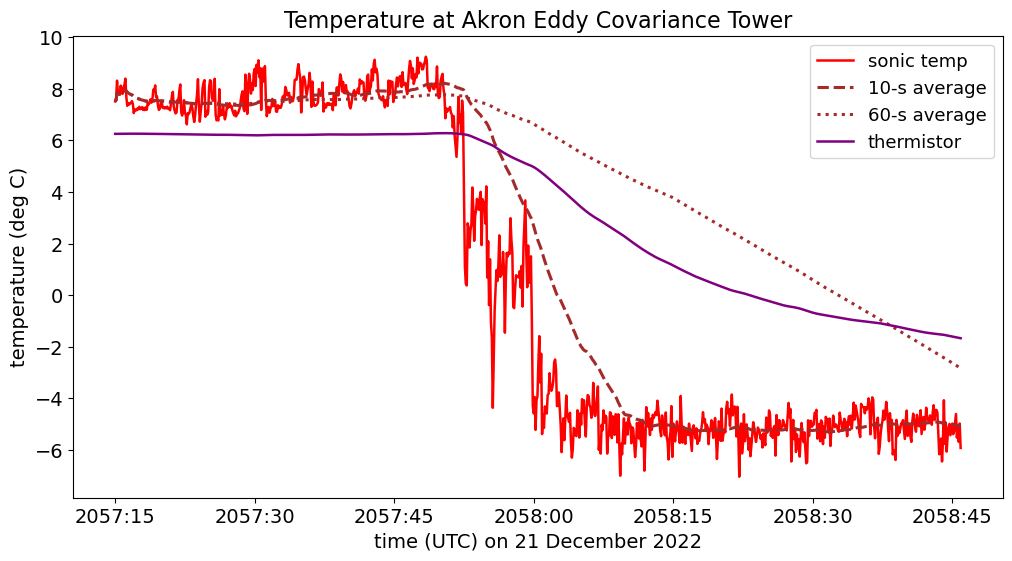

In [6]:
data_sub = usda['2022-12-21 20:57:15':'2022-12-21 20:58:45']

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(data_sub.index,data_sub['Ta_sonic'], label='sonic temp', color='red', lw=1.8, zorder=40)
### rolling means
ax.plot(data_sub.index,data_sub['Ta_sonic'].rolling(pd.Timedelta(seconds=10)).mean(), 
                                                             label='10-s average', color='brown', 
        linestyle='dashed', lw=2.2, zorder=40)

ax.plot(data_sub.index,data_sub['Ta_sonic'].rolling(pd.Timedelta(seconds=60)).mean(), 
                                                             label='60-s average', color='brown', 
                    linestyle='dotted', lw=2.2, zorder=40)

### and thermistor
ax.plot(data_sub.index,data_sub['Temperature (C)'], label='thermistor', color='purple', lw=1.8, 
                            zorder=40)

ax.set_ylabel("temperature (deg C)", fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=13)

# Define the date format
date_form = DateFormatter("%H%M:%S")
ax.xaxis.set_major_formatter(date_form)
# Ensure ticks fall once every other minute (interval=2) 
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=15))

ax.set_xlabel("time (UTC) on 21 December 2022", fontsize=14)

plt.title("Temperature at Akron Eddy Covariance Tower", fontsize=16)

plt.savefig("akron_ec_temp_tser.pdf", dpi=275, 
            bbox_inches='tight', transparent=False, facecolor='white')

plt.show()

### repeat the 2-panel for NWTC/NREL

In [7]:
nrel = pd.read_csv("NWTC.csv", parse_dates=[['DATE (MM/DD/YYYY)','MST']])
nrel.set_index("DATE (MM/DD/YYYY)_MST", inplace=True)

nrel = nrel.tz_localize("US/Mountain").tz_convert("Etc/GMT")

wspd = xr.DataArray(nrel['Avg Wind Speed @ 10m [m/s]'].values) * units('m/s')
wdir = xr.DataArray(nrel['Avg Wind Direction @ 10m [deg]'].values) * units('degrees')

### and redo U and V with this correction
nrel['u10'] = mpcalc.wind_components(wspd,wdir)[0].values
nrel['v10'] = mpcalc.wind_components(wspd,wdir)[1].values

nrel

/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_40454/2654094053.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  nrel = pd.read_csv("NWTC.csv", parse_dates=[['DATE (MM/DD/YYYY)','MST']])


,Temperature @ 2m [deg C],Temperature @ 50m [deg C],Temperature @ 80m [deg C],Station Pressure [mBar],Avg Wind Speed @ 10m [m/s],Peak Wind Speed @ 10m [m/s],Avg Wind Direction @ 10m [deg],Wind Direction @ Pk WS @ 10m [deg],u10,v10
DATE (MM/DD/YYYY)_MST,,,,,,,,,,
2022-12-21 07:00:00+00:00,3.382,3.536,3.417,811.206,6.905,8.670,289.5,294.9,6.508939,-2.304936
2022-12-21 07:01:00+00:00,3.307,3.469,3.334,811.218,5.544,7.059,284.4,294.3,5.369825,-1.378737
2022-12-21 07:02:00+00:00,3.253,3.443,3.287,811.192,6.677,7.639,279.8,281.4,6.579569,-1.136489
2022-12-21 07:03:00+00:00,3.225,3.483,3.326,811.149,5.896,7.295,288.8,280.7,5.581444,-1.900079
2022-12-21 07:04:00+00:00,3.227,3.501,3.317,811.134,5.880,7.876,274.0,261.9,5.865677,-0.410168
...,...,...,...,...,...,...,...,...,...,...
2022-12-23 06:55:00+00:00,-24.650,-19.770,-19.460,816.921,3.596,3.898,173.3,172.7,-0.419548,3.571442
2022-12-23 06:56:00+00:00,-24.600,-19.620,-19.420,817.026,3.599,3.769,173.8,169.8,-0.388690,3.577949
2022-12-23 06:57:00+00:00,-24.520,-19.620,-19.490,817.002,3.841,3.984,169.7,166.4,-0.686779,3.779102


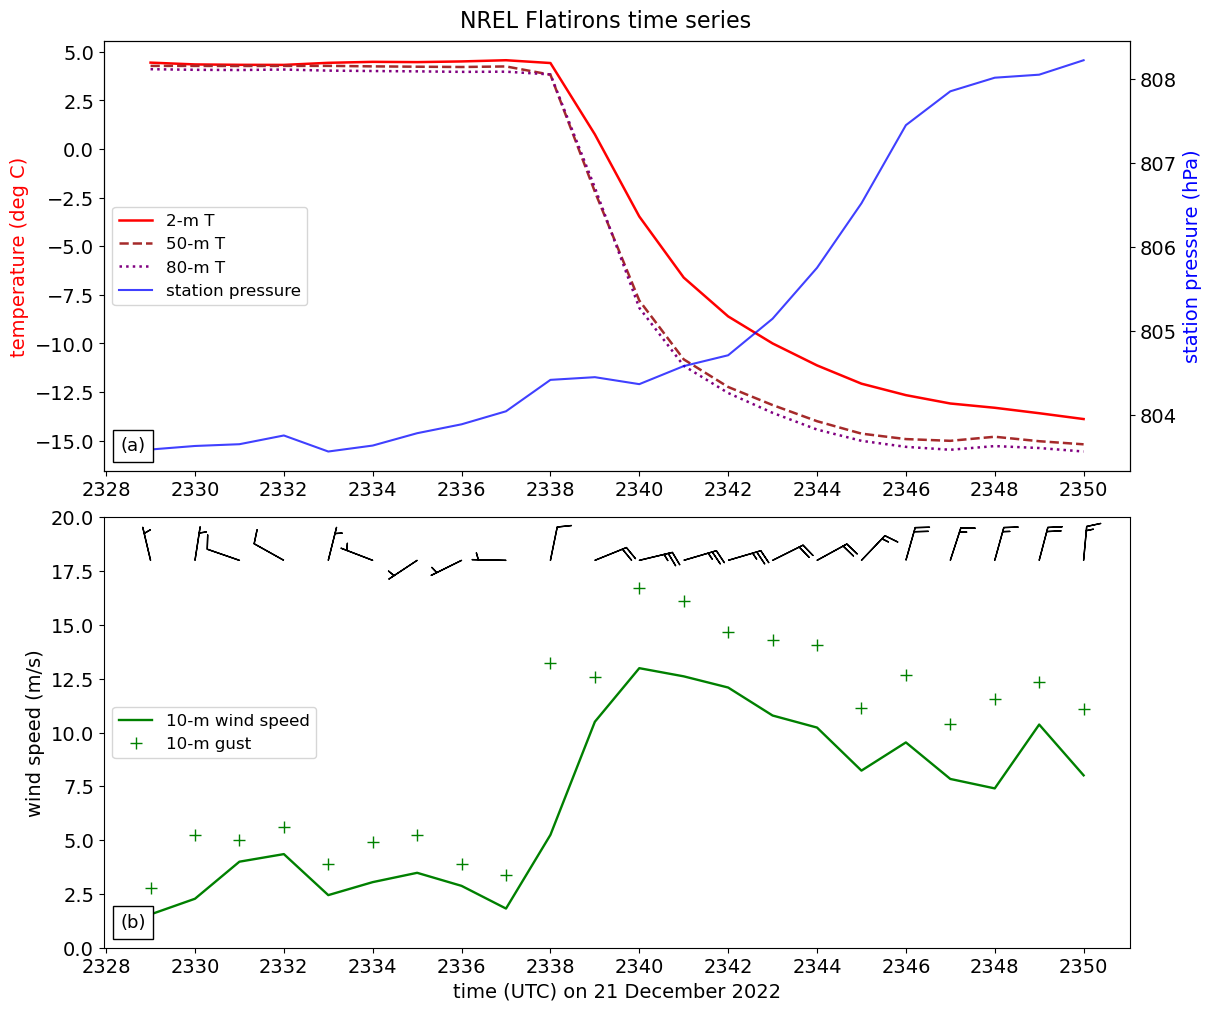

In [8]:
data_sub = nrel['2022-12-21 23:29':'2022-12-21 23:50']

# Plot the raw time series
fig, axs = plt.subplot_mosaic([
    ['t and p'],
    ['wind'],
], layout='constrained', figsize=(12,10))

axs['t and p'].plot(data_sub.index,data_sub['Temperature @ 2m [deg C]'], label='2-m T', color='red', lw=1.8, zorder=12)
axs['t and p'].plot(data_sub.index,data_sub['Temperature @ 50m [deg C]'], label='50-m T', color='brown',
                    linestyle='dashed', lw=1.8, zorder=12)
axs['t and p'].plot(data_sub.index,data_sub['Temperature @ 80m [deg C]'], label='80-m T', color='purple',
                    linestyle='dotted', lw=1.8, zorder=12)

axs['t and p'].set_ylabel("temperature (deg C)", fontsize=14, color='red')
axs['t and p'].tick_params(axis='both', labelsize=14)

ax2 = axs['t and p'].twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(data_sub.index,data_sub['Station Pressure [mBar]'],label='station pressure', color='blue', lw=1.5, zorder=10, alpha=0.75)

ax2.set_ylabel("station pressure (hPa)", fontsize=14, color='blue')
ax2.tick_params(axis='both', labelsize=14)

# Define the date format
date_form = DateFormatter("%H%M")
ax2.xaxis.set_major_formatter(date_form)
# Ensure ticks fall once every other minute (interval=2) 
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))

### panel label
text = AnchoredText("(a)",
                loc='lower left', prop={'size': 13}, frameon=True, zorder=20)
ax2.add_artist(text)

# ask matplotlib for the plotted objects and their labels
lines, labels = axs['t and p'].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, fontsize=12, loc='center left')


### now do wind
axs['wind'].plot(data_sub.index,data_sub['Avg Wind Speed @ 10m [m/s]'], label='10-m wind speed', color='green', lw=1.7, zorder=6)
axs['wind'].plot(data_sub.index,data_sub['Peak Wind Speed @ 10m [m/s]'], '+', label='10-m gust', color='green',
                  zorder=6, markersize=9)

## add barbs
thin_by = 1  ## plot a barb every nth time
axs['wind'].barbs(data_sub.index[::thin_by],18,data_sub['u10'][::thin_by]*1.943844,data_sub['v10'][::thin_by]*1.943844)

axs['wind'].set_ylabel("wind speed (m/s)", fontsize=14)
axs['wind'].tick_params(axis='both', labelsize=14)
axs['wind'].set_xlabel("time (UTC) on 21 December 2022", fontsize=14)

### date format again
axs['wind'].xaxis.set_major_formatter(date_form)
axs['wind'].xaxis.set_major_locator(mdates.MinuteLocator(interval=2))

axs['wind'].set_ylim(0,20)

axs['wind'].legend(fontsize=12, loc='center left')
### panel label
text = AnchoredText("(b)",
                loc='lower left', prop={'size': 13}, frameon=True, zorder=20)
axs['wind'].add_artist(text)

plt.suptitle("NREL Flatirons time series", fontsize=16)

plt.savefig("nrel_2panel_tser.pdf", dpi=275, 
            bbox_inches='tight', transparent=False, facecolor='white')

plt.show()



In [14]:
usda_share.to_csv("usda_akron_21dec22_share.csv")

#### compare EC and NREL data on similar timescales

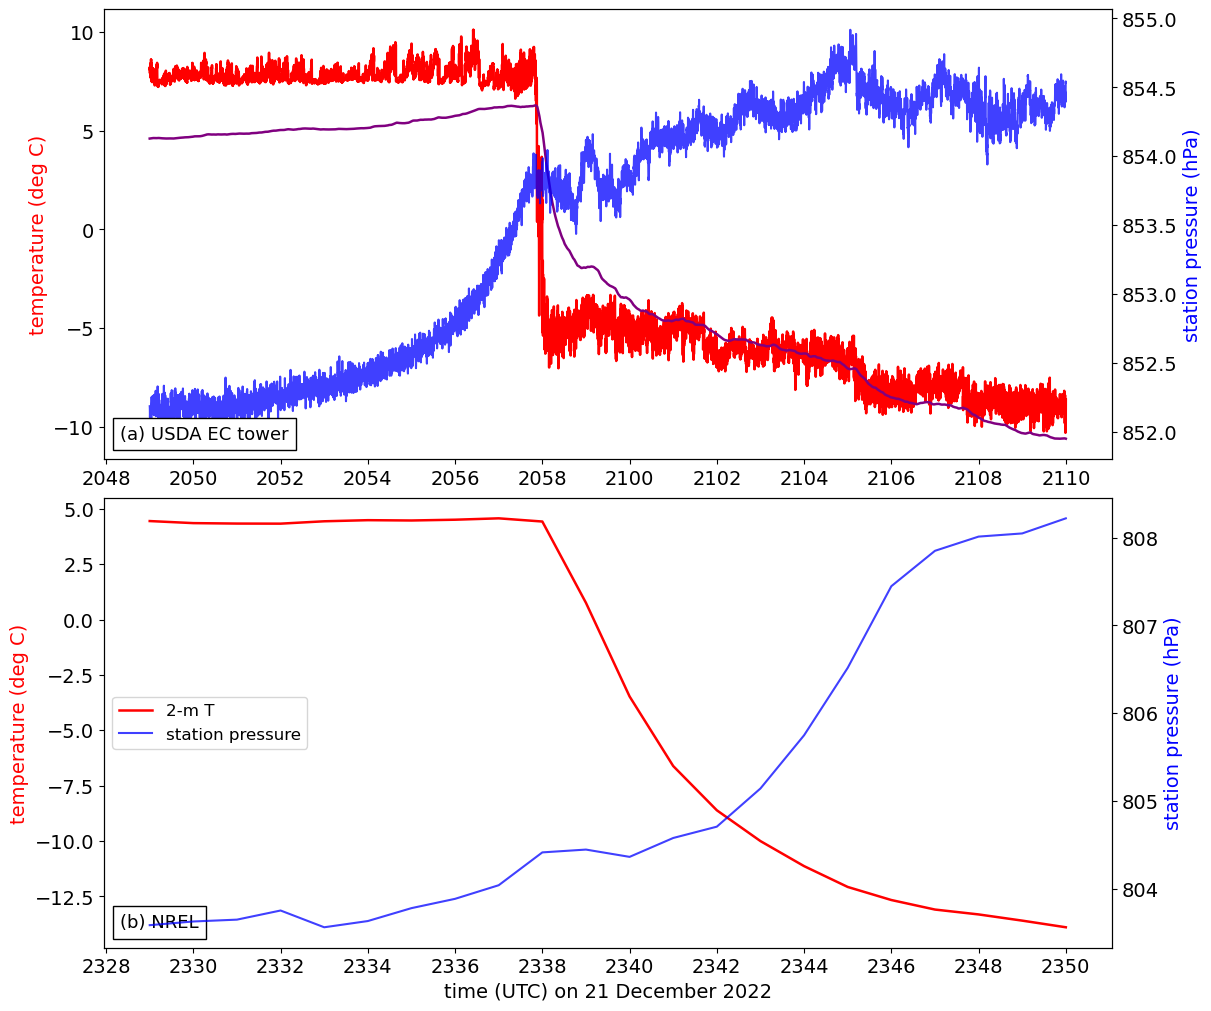

In [16]:
data_ec_sub = usda['2022-12-21 20:49':'2022-12-21 21:09']
data_nrel_sub = nrel['2022-12-21 23:29':'2022-12-21 23:50']

# Plot the raw time series
fig, axs = plt.subplot_mosaic([
    ['USDA'],
    ['NREL'],
], layout='constrained', figsize=(12,10))

axs['USDA'].plot(data_ec_sub.index,data_ec_sub['Ta_sonic'], label='sonic T', color='red', lw=1.8, zorder=12)
axs['USDA'].plot(data_ec_sub.index,data_ec_sub['Temperature (C)'], label='thermistor T', color='purple', lw=1.8, zorder=12)

axs['USDA'].set_ylabel("temperature (deg C)", fontsize=14, color='red')
axs['USDA'].tick_params(axis='both', labelsize=14)

ax2 = axs['USDA'].twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(data_ec_sub.index,data_ec_sub['pressure'],label='station pressure', color='blue', lw=1.5, zorder=10, alpha=0.75)

ax2.set_ylabel("station pressure (hPa)", fontsize=14, color='blue')
ax2.tick_params(axis='both', labelsize=14)

# Define the date format
date_form = DateFormatter("%H%M")
ax2.xaxis.set_major_formatter(date_form)
# Ensure ticks fall once every other minute (interval=2) 
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))

### panel label
text = AnchoredText("(a) USDA EC tower",
                loc='lower left', prop={'size': 13}, frameon=True, zorder=20)
ax2.add_artist(text)

#### now repeat for NREL
axs['NREL'].plot(data_nrel_sub.index,data_nrel_sub['Temperature @ 2m [deg C]'], label='2-m T', color='red', lw=1.8, zorder=12)

axs['NREL'].set_ylabel("temperature (deg C)", fontsize=14, color='red')
axs['NREL'].tick_params(axis='both', labelsize=14)

ax4 = axs['NREL'].twinx()  # instantiate a second axes that shares the same x-axis
ax4.plot(data_nrel_sub.index,data_nrel_sub['Station Pressure [mBar]'],label='station pressure', color='blue', lw=1.5, zorder=10, alpha=0.75)

ax4.set_ylabel("station pressure (hPa)", fontsize=14, color='blue')
ax4.tick_params(axis='both', labelsize=14)

# Define the date format
date_form = DateFormatter("%H%M")
ax4.xaxis.set_major_formatter(date_form)
# Ensure ticks fall once every other minute (interval=2) 
ax4.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))

axs['NREL'].set_xlabel("time (UTC) on 21 December 2022", fontsize=14)

# ask matplotlib for the plotted objects and their labels
lines, labels = axs['NREL'].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax4.legend(lines + lines2, labels + labels2, fontsize=12, loc='center left')

### panel label
text = AnchoredText("(b) NREL",
                loc='lower left', prop={'size': 13}, frameon=True, zorder=24)
axs['NREL'].add_artist(text)

#plt.suptitle("NREL Flatirons time series", fontsize=16)

plt.savefig("usda_nrel_tandp_compare_tser.png", dpi=275, 
            bbox_inches='tight', transparent=False, facecolor='white')

plt.show()

